🚀 Starting data fetching for BTC_USDT (1d, limit=100)...
⏳ Fetching DVOL history from Deribit...
    - Fetching DVOL from Deribit API...
🔄 Aligning Price and DVOL data...
✅ Data aligned. Total data points: 100
📊 Factor calculation complete. Generating chart...


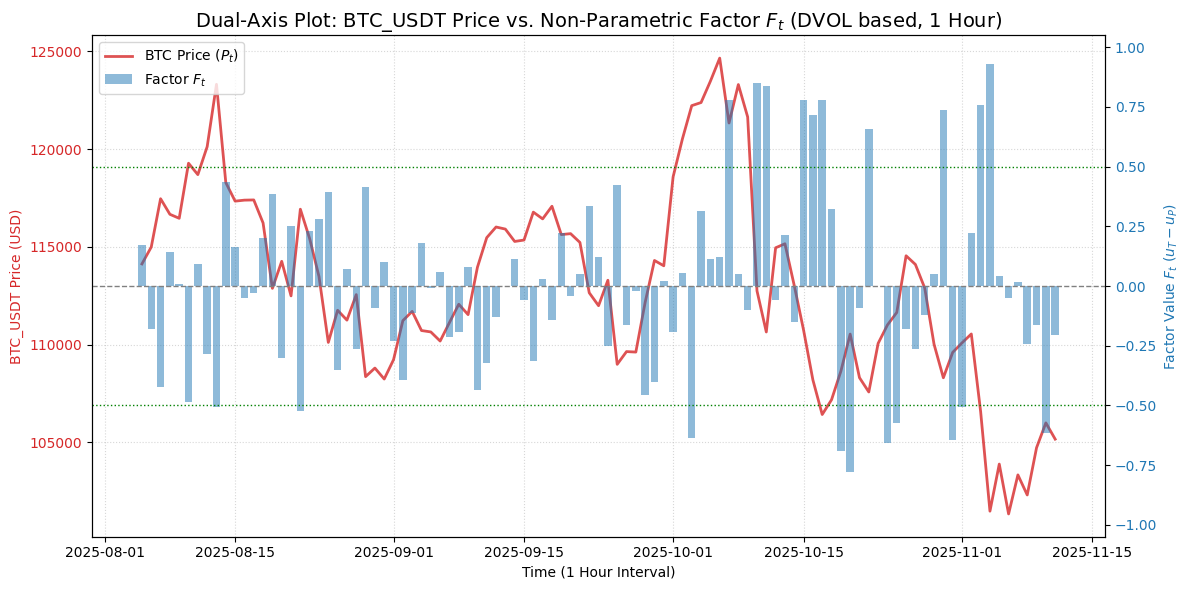


📝 Last 10 Trading Signals:
               Price  DVOL_Close       rtP   rtT        uP        uT  \
time                                                                   
2025-11-02  110550.2       43.56  0.004125  0.21  0.565657  0.787879   
2025-11-03  106579.6       43.85 -0.036578  0.29  0.060606  0.818182   
2025-11-04  101486.7       45.85 -0.048964  2.00  0.020202  0.949495   
2025-11-05  103895.2       48.50  0.023455  2.65  0.939394  0.979798   
2025-11-06  101345.3       46.51 -0.024849 -1.99  0.111111  0.060606   
2025-11-07  103341.2       47.42  0.019503  0.91  0.878788  0.893939   
2025-11-08  102316.2       44.91 -0.009968 -2.51  0.272727  0.030303   
2025-11-09  104731.1       45.07  0.023328  0.16  0.929293  0.767677   
2025-11-10  106002.9       44.80  0.012070 -0.27  0.757576  0.141414   
2025-11-11  105170.4       44.30 -0.007885 -0.50  0.313131  0.106061   

                   F   signal  
time                           
2025-11-02  0.222222     long  
2025-11-03 

In [4]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta

# --- Configurations ---
GATEIO_HOST = "https://api.gateio.ws"
DERIBIT_HOST = "https://www.deribit.com/api/v2/public" # Deribit Public API
GATEIO_PREFIX = "/api/v4"
# ----------------------

# -----------------------------
# 1. Fetch Spot K-Line History Close Prices (Gate.io)
# -----------------------------
def fetch_price_history(symbol="BTC_USDT", interval="1d", limit=100): # 修正 interval 預設為 1d
    """
    從 Gate.io 抓取 K 線歷史收盤價，並返回帶有時間戳的 DataFrame。
    """
    url = f"{GATEIO_HOST}{GATEIO_PREFIX}/spot/candlesticks"
    params = {
        "currency_pair": symbol,
        "interval": interval, 
        "limit": limit
    }
    resp = requests.get(url, params=params)
    resp.raise_for_status()
    data = resp.json()
    
    # 修正: Gate.io API v4 K線數據格式已變更，現在返回 8 個欄位。
    # 數據格式: [time, volume, close, high, open, low, quote_volume, count]
    df = pd.DataFrame(data, columns=['time', 'volume', 'close', 'high', 'open', 'low', 'quote_volume', 'count'])
    
    # 轉換時間和排序
    df['time'] = pd.to_datetime(df['time'].astype(int), unit='s')
    df['close'] = df['close'].astype(float)
    df = df.sort_values('time').reset_index(drop=True)
    
    # 篩選出需要的欄位
    return df[['time', 'close']].rename(columns={'close': 'Price'})

# -----------------------------
# 2. Fetch DVOL Historical Data (Deribit)
# -----------------------------
# 修正 resolution 預設為 3600 (1 小時)
def fetch_dvol_history(start_time_ms, end_time_ms, index_name="BTC_DVOL", resolution=3600, currency="BTC"): 
    """
    從 Deribit 抓取 DVOL 歷史數據。
    resolution=3600 表示 3600 秒，即 1 小時。
    """
    url = f"{DERIBIT_HOST}/get_volatility_index_data"
    params = {
        "index_name": index_name,
        "start_timestamp": start_time_ms,
        "end_timestamp": end_time_ms,
        "resolution": resolution, # 3600 seconds = 1 hour (修正)
        "currency": currency 
    }
    
    print(f"    - Fetching DVOL from Deribit API...")
    resp = requests.get(url, params=params)
    resp.raise_for_status() # 會在 400/500 錯誤時拋出異常
    data = resp.json()
    
    if data['result'] is None or 'data' not in data['result']:
        raise ValueError("DVOL data not found or API response error.")
        
    dvol_data = data['result']['data']
    
    # 數據格式: [timestamp, open, high, low, close]
    df = pd.DataFrame(dvol_data, columns=['time_ms', 'open', 'high', 'low', 'DVOL_Close'])
    df['time'] = pd.to_datetime(df['time_ms'], unit='ms')
    df['DVOL_Close'] = df['DVOL_Close'].astype(float)
    
    return df[['time', 'DVOL_Close']].sort_values('time')

# -----------------------------
# Main Program
# -----------------------------
def main():
    symbol = "BTC_USDT"
    # 週期改為 1 小時
    interval = "1d" 
    limit = 100 

    print(f"🚀 Starting data fetching for {symbol} ({interval}, limit={limit})...")
    
    # 1. Fetch Price History (Gate.io)
    try:
        # 傳遞 interval="1d"
        df_price = fetch_price_history(symbol, interval=interval, limit=limit)
    except Exception as e:
        print(f"🔴 Failed to fetch price history from Gate.io: {e}")
        print("💡 提示：此錯誤通常是由 Gate.io API 返回的 K 線欄位數量變更引起。")
        return

    # 設置 DVOL 抓取時間範圍 (以價格數據的最早和最晚時間為準)
    end_time = df_price['time'].max()
    start_time = df_price['time'].min()
    
    # 轉換為毫秒時間戳 (Deribit API 需要毫秒)
    end_time_ms = int(end_time.timestamp() * 1000)
    # 往前推一些時間確保抓到對齊點
    start_time_ms = int((start_time - timedelta(hours=1)).timestamp() * 1000) 

    # 2. Fetch DVOL Time Series (Deribit)
    print("⏳ Fetching DVOL history from Deribit...")
    try:
        # 由於 price 是 1d，DVOL 預設 resolution=3600 (1d)
        df_dvol = fetch_dvol_history(start_time_ms, end_time_ms, index_name="BTC_DVOL", currency="BTC")
    except Exception as e:
        print(f"🔴 Failed to fetch DVOL history: {e}")
        return
        
    # --- 3. Data Alignment ---
    print("🔄 Aligning Price and DVOL data...")
    
    # 使用 pd.merge_asof 進行近似時間匹配
    df_aligned = pd.merge_asof(
        left=df_price, 
        right=df_dvol, 
        on='time', 
        direction='nearest'
    )
    
    # 移除 NaN 數據點
    df_aligned = df_aligned.dropna(subset=['DVOL_Close']).set_index('time')
    
    if len(df_aligned) < 2:
        print("🔴 數據點不足，無法計算報酬率和變化量。")
        return
        
    print(f"✅ Data aligned. Total data points: {len(df_aligned)}")

    # --- 4. Calculate Factor ---
    
    # rtP: Log Return of Price
    df_aligned['rtP'] = np.log(df_aligned['Price']).diff()
    # rtT: Change in DVOL (IV)
    df_aligned['rtT'] = df_aligned['DVOL_Close'].diff()
    
    # 移除第一筆 NaN (因為 diff 計算)
    df_factor = df_aligned.dropna(subset=['rtP', 'rtT']).copy() # 使用 .copy() 避免 SettingWithCopyWarning

    # Calculate Non-Parametric Factor F
    df_factor['uP'] = df_factor['rtP'].rank(pct=True)
    df_factor['uT'] = df_factor['rtT'].rank(pct=True)
    df_factor['F'] = df_factor['uT'] - df_factor['uP']

    print("📊 Factor calculation complete. Generating chart...")

    # --- 5. Plotting (Dual Y-Axis: Price + Factor) ---
    
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # --- Primary Y-Axis (Left): Price ---
    color = 'tab:red'
    ax1.set_xlabel('Time (1 Hour Interval)') # 更新標籤
    ax1.set_ylabel(f'{symbol} Price (USD)', color=color)
    ax1.plot(df_factor.index, df_factor['Price'], color=color, linewidth=2, label='BTC Price ($P_t$)', alpha=0.8)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, which='both', linestyle=':', alpha=0.5)

    # --- Secondary Y-Axis (Right): Factor F ---
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Factor Value $F_t$ ($u_T - u_P$)', color=color)  
    
    # 繪製因子 (使用 Bar Plot 更清晰)
    time_diffs = df_factor.index.to_series().diff().dropna()
    bar_width = time_diffs.min() * 0.8 if len(time_diffs) > 0 else timedelta(minutes=48)
    
    ax2.bar(df_factor.index, df_factor['F'], color=color, alpha=0.5, label='Factor $F_t$', width=bar_width)
    
    ax2.tick_params(axis='y', labelcolor=color)
    
    # 因子零軸和閾值線
    ax2.axhline(0, color='gray', linestyle='--', linewidth=1)
    
    threshold = 0.5
    ax2.axhline(threshold, color='green', linestyle=':', linewidth=1)
    ax2.axhline(-threshold, color='green', linestyle=':', linewidth=1)
    ax2.set_ylim(-1.05, 1.05) 

    # --- Finalize Plot ---
    plt.title(f"Dual-Axis Plot: {symbol} Price vs. Non-Parametric Factor $F_t$ (DVOL based, 1 Hour)", fontsize=14)
    
    # 統一圖例
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    fig.tight_layout()
    plt.show()

    # --- Generate Trading Signals ---
    df_factor['signal'] = df_factor['F'].apply(lambda x: 'long' if x > 0.05 else ('short' if x < -0.05 else 'neutral'))
    
    print("\n📝 Last 10 Trading Signals:")
    print(df_factor[['Price', 'DVOL_Close', 'rtP', 'rtT', 'uP', 'uT', 'F', 'signal']].tail(10))
    
if __name__ == "__main__":
    main()